In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # pip3 install missingno
import seaborn as sns 
sns.set_style("whitegrid")
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1. Load Data

In [2]:
df=pd.read_csv("sothebys.csv", index_col=0)

In [3]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [4]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

In [5]:
#clean up birth_year
df.birth_year=pd.to_numeric(df.birth_year,errors='coerce').fillna(0).astype(np.int64)

## 2. Add Features

In [6]:
# Add year, month and season for auction time
df["auc_date"] = pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df['auc_season'] = df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [7]:
# Add a boolean column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["is_untitled"]=np.where(df["lot_title"].str.contains(words), 1, 0)
df.is_untitled.value_counts()

0    16574
1     6137
Name: is_untitled, dtype: int64

In [8]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
df["auc_order"]= df.groupby("auction_id")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

In [9]:
# returns nth_in_auction divided by lot_number = percentage through the auction the lot when lot was shown
lot_order_df = df[['nth_in_auction', 'number_of_lots']].copy()
df['percent_in_auction'] = np.round(lot_order_df.nth_in_auction / lot_order_df.number_of_lots, 3)*100

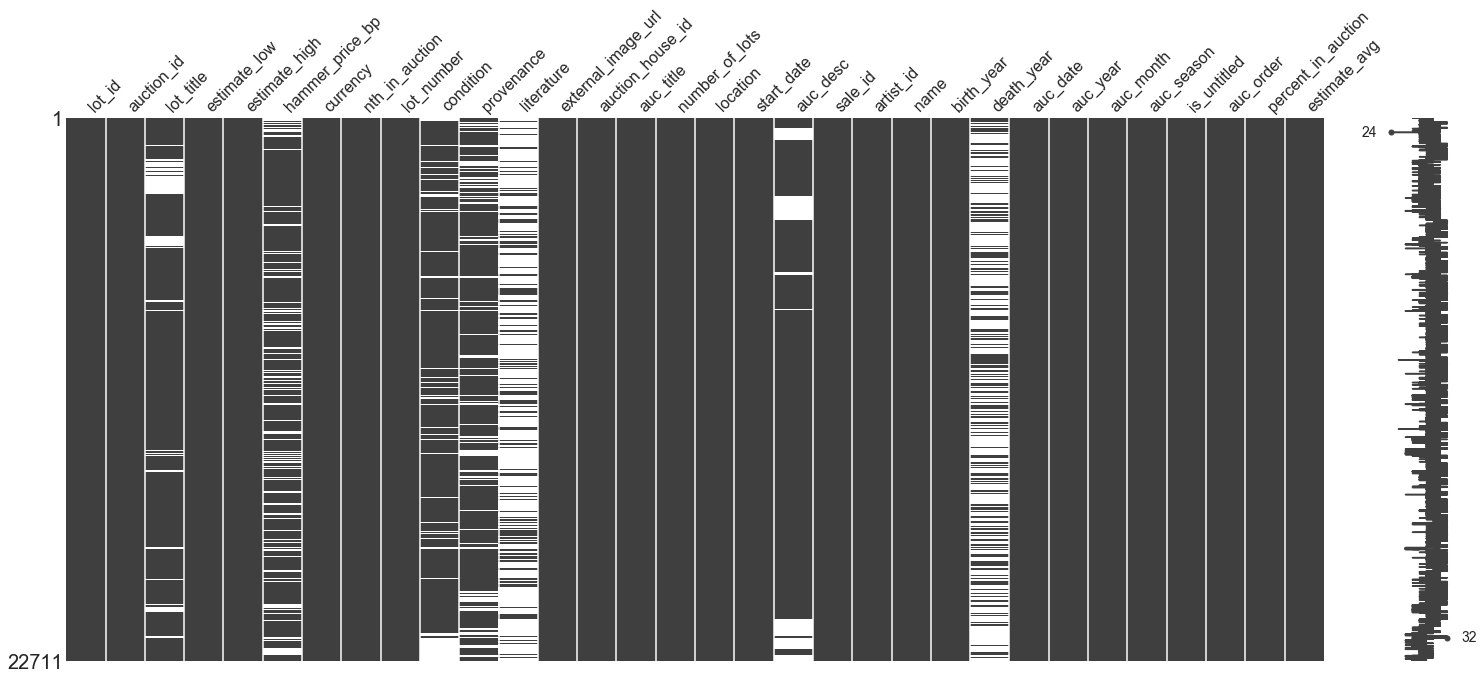

In [10]:
# Add avg_estimate
df["estimate_avg"]=(df["estimate_low"] + df["estimate_high"])/2

msno.matrix(df)

## 3. Convert Currency

In [11]:
# pip install --user currencyconverter
from currency_converter import CurrencyConverter
from datetime import datetime
c = CurrencyConverter(fallback_on_wrong_date=True, fallback_on_missing_rate=True)

hammer_price = df[['hammer_price_bp', 'currency', 'start_date']].copy()
est_low = df[['estimate_low', 'currency', 'start_date']].copy()
est_high = df[['estimate_high', 'currency', 'start_date']].copy()
est_avg = df[['estimate_avg', 'currency', 'start_date']].copy()

hammer_price.start_date = hammer_price.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_low.start_date = est_low.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_high.start_date = est_high.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_avg.start_date = est_avg.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)

df['hammer_price_bp_usd'] = hammer_price.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_low_usd'] = est_low.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)    
df['estimate_high_usd'] = est_high.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_avg_usd'] = est_avg.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)

In [12]:
df.sample(20)

,lot_id,auction_id,lot_title,estimate_low,estimate_high,hammer_price_bp,currency,nth_in_auction,lot_number,condition,provenance,literature,external_image_url,auction_house_id,auc_title,number_of_lots,location,start_date,auc_desc,sale_id,artist_id,name,birth_year,death_year,auc_date,auc_year,auc_month,auc_season,is_untitled,auc_order,percent_in_auction,estimate_avg,hammer_price_bp_usd,estimate_low_usd,estimate_high_usd,estimate_avg_usd
3421,21664,218,"WHITE NIGHT, NEW YORK, 1930SILVER PRINT, PRINT...",4000.0,5000.0,16250.0,EUR,60,67,En très bon état général. Coins et bords légèr...,"Vente Sotheby's Photographs, New York, 26-27 a...",NaN,http://www.sothebys.com/content/dam/default/un...,1,"Photographs, Furniture, and Works of Art from ...",191,PARIS,2009-09-23 12:30:00.000,NaN,F9093,8293,Adolf Fassbender,1884,1980),2009-09-23,2009,9,4,0,4,31.4,4500.0,24022.38,5913.20,7391.50,6652.35
17797,2767,40,TORN PAPER PIECE RED,4000.0,6000.0,7500.0,GBP,161,330,Colour:\nThe colours in the catalogue illustra...,NaN,"Courtesy of Annemarie Verna Galerie, Zurich.\n...",http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Day Auction,265,LONDON,2014-10-18 10:00:00.567,RESULTS\n\nThe Contemporary Art Day Auction to...,L14025,43,Sol LeWitt,1928,2007,2014-10-18,2014,10,4,0,7,60.8,5000.0,12094.63,6450.47,9675.71,8063.09
6933,19394,207,UNTITLED,400000.0,600000.0,422500.0,USD,24,130,This work is in good overall condition. The sh...,"<p>Markus Mizne, U.S.A. (acquired directly fro...",Sotheby's is priveleged to offer a wonderful s...,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Day Auction,286,NEW YORK,2010-11-10 15:00:00.000,OVERVIEW\n\nThe November 10th Day Auction of C...,N08679,7841,Willem de Kooning,0,1997),2010-11-10,2010,11,4,1,2,8.4,500000.0,422500.00,400000.00,600000.00,500000.00
21401,1317,11,NATIONAL MARTYRS SERIES: THE DEATH OF LIU SHAOQI,8000.0,12000.0,10000.0,USD,114,115,This work is in generally very good condition ...,"<p>Pasadena, Pacific Asia Museum, <em>""I Don't...",NaN,http://www.sothebys.com/content/dam/default/un...,1,"Contemporary Art Asia: China, Korea, Japan",274,NEW YORK,2007-09-20 14:00:00.000,NaN,N08343,826,Huang Fabang,1938,NaN,2007-09-20,2007,9,4,0,5,41.6,10000.0,10000.00,8000.00,12000.00,10000.00
14550,5339,101,JAGGED AND ARCHED (MAQUETTE),300000.0,400000.0,346000.0,USD,12,12,This work is in very good condition overall. A...,"Perls Galleries, New York<br>Acquired by the p...",As Alexander Calder forged a revolutionary pat...,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Curated,348,NEW YORK,2016-03-03 15:00:00.955,Results: Our March Contemporary Curated auctio...,N09473,18,Alexander Calder,1898,1976,2016-03-03,2016,3,2,0,1,3.4,350000.0,346000.00,300000.00,400000.00,350000.00
7169,11214,145,THE FAKE ROTHKO,250000.0,350000.0,1426500.0,GBP,34,35,Colour:\nThe colour in the illustrated catalog...,"Galerie Judin, Berlin\n<p>Acquired directly fr...",Exploring the historical and the personal in a...,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Evening Auction,57,LONDON,2014-06-30 18:00:00.800,RESULTS\n\nThe Best of British drove Sotheby’s...,L14022,1295,Adrian Ghenie,1977,NaN,2014-06-30,2014,6,3,0,8,59.6,300000.0,2430834.31,426013.72,596419.21,511216.47
10231,13244,167,"CONCETTO SPAZIALE, LE CHIESE DI VENEZIA",4000000.0,6000000.0,4450500.0,GBP,15,15,Colour: The colours in the catalogue are fairl...,"Michel Tapié, Paris<br>Ada Minola, Turin<br>Re...",A supreme example of Lucio Fontana’s tireless ...,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Evening Auction,67,LONDON,2013-06-26 18:00:00.153,OVERVIEW\n\nThe Contemporary Art Evening Aucti...,L13022,68,Lucio Fontana,1899,1968,2013-06-26,2013,6,3,0,4,22.4,5000000.0,6833684.51,6141947.65,9212921.48,7677434.57
3917,21816,214,CINQUE X CINQUE VENTICINQUE,8000.0,12000.0,10625.0,EUR,96,158,This work is in generally good overall conditi...,Opera registrata presso l'Archivio Alighiero 

## 4. Export to CSV

In [13]:
df.to_csv("final_sothebys.csv")